# 3. 추가 변수 및 지표 생성

## 1. 교차로

+ 격자별 교통사고 건수 시각화 결과 횡단보도, 신호등이 많은 교차로에서 많이 발생하는 것을 확인
+ 격자내 교차로 개수 변수 생성

In [55]:
cross = [a in ["32", "4"] for a in data23.link_type] #교차로 통로, 복합 교차로
sum(cross)
#교차로 총 385개

385

In [56]:
cross_geo = data23[cross].buffer(0.0001).unary_union

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [57]:
data23_b = data23[cross].copy()
data23_b["geometry"] = data23_b["geometry"].buffer(0.0001).values #선분을 두껍게 buffer
data23_b.crs = data2.crs
data23_b["cross1"] = 1

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [58]:
merge_i = gpd.sjoin(data23_b, data2, op = "intersects", how = 'right')
cross1 = merge_i.groupby('gid').agg({'cross1': 'sum'})

## 2. 사거리, 삼거리

+ 도로유형상 교차로에 해당되지 않으나, 다수의 횡단로가 존재하는 사거리, 삼거리 변수 생성

In [59]:
#도로가 교차하는 모든 지점 추출
cross_dict = {}
data23_2 = data23[data23.link_type == "32768"]

for index, row in data23_2.iterrows():
    cross_dict[index] = []
    for index2, row2 in data23_2.drop([index], axis=0).iterrows():
        if row.geometry.intersects(row2.geometry):
            cross_dict[index].append(row.geometry.intersection(row2.geometry).coords[:])

In [60]:
cross_geo_dic = {"lon":[], "lat":[]}

for key, value in cross_dict.items():
    for i in range(len(value)):
        cross_geo_dic["lon"].append(value[i][0][0])
        cross_geo_dic["lat"].append(value[i][0][1])

In [61]:
cross_all = pd.DataFrame(cross_geo_dic).drop_duplicates()

cross_all_geo = gpd.GeoDataFrame(cross_all, geometry = gpd.points_from_xy(cross_all.lon, cross_all.lat))
cross_all_geo.crs = data2.crs

In [62]:
#각 사거리의 중점에서 근처 횡단보도까지의 거리 측정

distance_3 = []

for i in cross_all_geo['geometry']:
    temp = []
    for j in data17_p['geometry']:
        temp.append(i.distance(j))
    idx = temp.index(sorted(temp)[3])
    geom=[i,data17_p.iloc[idx,1]]
    gdf=gpd.GeoDataFrame(geometry=geom,crs={'init':'epsg:4326'})
    gdf.to_crs(epsg=5186,inplace=True) # 한국 중부 좌표계
    l_3=gdf.distance(gdf.shift())[1]
    distance_3.append(l_3)
    

cross_all_geo['crosswalk_1'] = distance_3

/opt/app-root/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:5186
Right CRS: None

  del sys.path[0]


In [63]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)
cross_all_geo["cross2"] = 1
cross_all_geo.sort_values("crosswalk_1")
cross_all_geo_cut = cross_all_geo[cross_all_geo.crosswalk_1 < 51]
#4번개 횡단보도와의 거리가 5미터 이하인 것들로 필터링

In [64]:
merge_j = gpd.sjoin(cross_all_geo_cut, data2, op = "within", how = 'right')
cross2 = merge_j.groupby('gid').agg({'cross2': 'sum'})

## 3. 격자별 유동인구

+ 시각화를 통해 학교보다 학원가 근처에서 어린이 교통사고가 다수 발생하는 것을 확인
+ 초등생들의 하교 시간대인 1~4시 사이의 격자별 유동인구 위주로 파악
+ 1월부터 12월까지 월별로 측정된 유동인구 데이터

+ 방학기간인 7-8, 1-2월과 그렇지 않은 기간으로 분리

In [65]:
vacation  = [a in [201907, 201908,201901,201902] for a in data8.STD_YM]
data8_s = data8[list(~np.array(vacation))]
data8_v = data8[vacation]

In [66]:
data8_s1 = data8_s.groupby(["lon","lat"]).mean()
data8_s1.reset_index(level=0, inplace=True)
data8_s1.reset_index(level=0, inplace=True)

data8_s_geo = gpd.GeoDataFrame(data8_s1, geometry= gpd.points_from_xy(data8_s1.lon, data8_s1.lat))
data8_s_geo.crs = data2.crs
merge_p = gpd.sjoin(data8_s_geo, data2[["gid","geometry"]], op='within', how="right")

In [67]:
#격자별 총 유동인구(학기중)
people_s  = merge_p.groupby("gid").sum()

In [68]:
# 동일한 방식으로 비학기 평균 유동인구
data8_v1 = data8_v.groupby(["lon","lat"]).mean()
data8_v1.reset_index(level=0, inplace=True)
data8_v1.reset_index(level=0, inplace=True)

data8_v_geo = gpd.GeoDataFrame(data8_v1, geometry= gpd.points_from_xy(data8_v1.lon, data8_v1.lat))
data8_v_geo.crs = data2.crs

merge_p2 = gpd.sjoin(data8_v_geo, data2[["gid","geometry"]], op='within', how="right")
people_v  = merge_p2.groupby("gid").sum()

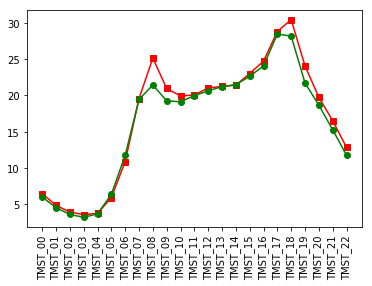

<Figure size 3600x2160 with 0 Axes>

In [69]:
plt.plot(people_s.mean()[4:-1], marker='s', color='r')
plt.plot(people_v.mean()[4:-1], marker='o', color='g')
plt.xticks(rotation = 90)
plt.figure(figsize=(50,30))
plt.show()

+ 실제로 방학시즌에 아침 저녁 유동인구가 더 적은 것 확인.
+ 학기중 유동인구 기준으로 변수 사용

In [70]:
moving = pd.merge(people_s, people_v, on = "gid",  how = "inner")
moving.drop(["index_left_x","lat_x","lon_x","STD_YM_x"], axis =1, inplace = True)

moving_log = moving.copy() 
moving_log.iloc[:,:] = np.log1p(moving_log.values) #skewness 감소를 위해 로그 취해줌

## 4. 아파트단지, 학원가 밀접도

+ 가장 가까운 주택가, 학원가로부터 얼마나 떨어져있는지를 변수로 수치화
+ 단순히 가장 가까운 건물로 할 시 변수가 지나치게 획일화될 수 있고 의미 해석도 모호해짐
+ 아파트 단지, 학원 단지를 군집화하여 가장 가까운 군집과의 거리를 측정

In [71]:
# 아파트 단지
apt_list = [s in ["02000","02001"] for s in data27.BDTYP_CD]
data27_apt = data27[apt_list]

In [72]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [73]:
data27_apt['lon'] = data27_apt['geometry'].centroid.x
data27_apt['lat'] = data27_apt['geometry'].centroid.y

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/opt/app-root/lib/python3.6/site-packages/geopandas/geodataframe.py:1190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [74]:
data27_apt

,BDTYP_CD,BULD_NM,BULD_NM_DC,BULD_SE_CD,BUL_MAN_NO,EMD_CD,GRO_FLO_CO,LNBR_MNNM,LNBR_SLNO,UND_FLO_CO,geometry,lon,lat
50,02001,None,None,0,12846,103,1,805,1,0,"MULTIPOLYGON (((127.07068 37.13476, 127.07063 ...",127.070666,37.134787
51,02001,원동청구아파트,101동,0,12842,103,15,805,1,1,"MULTIPOLYGON (((127.07153 37.13556, 127.07153 ...",127.071361,37.135498
52,02001,원동청구아파트,104동,0,12850,103,15,805,1,1,"MULTIPOLYGON (((127.07176 37.13492, 127.07176 ...",127.071462,37.134856
53,02001,원동청구아파트,103동,0,12851,103,15,805,1,1,"MULTIPOLYGON (((127.07093 37.13513, 127.07093 ...",127.070770,37.135071
54,02001,None,None,0,12844,103,1,805,1,0,"MULTIPOLYGON (((127.07124 37.13516, 127.07118 ...",127.071208,37.135181
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15005,02001,None,"오피스텔,상가",0,21476,113,23,587,0,2,"MULTIPOLYGON (((127.04605 37.18600, 127.04606 ...",127.046014,37.185927
15361,02001,None,101동,0,23175,103,25,907,0,0,"MULTIPOLYGON (((127.08664 37.14186, 127.08669 ...",127.086508,37.141810
15362,02001,None,102동,0,23176,103,25,907,0,0,"MULTIPOLYGON (((127.08753 37.14186, 127.08758 ...",127.087398,37.141806
15363,02001,None,103동,0,23177,103,1,907,0,0,"MULTIPOLYGON (((127.08841 37.14185, 127.08846 ...",127.088281,37.141802


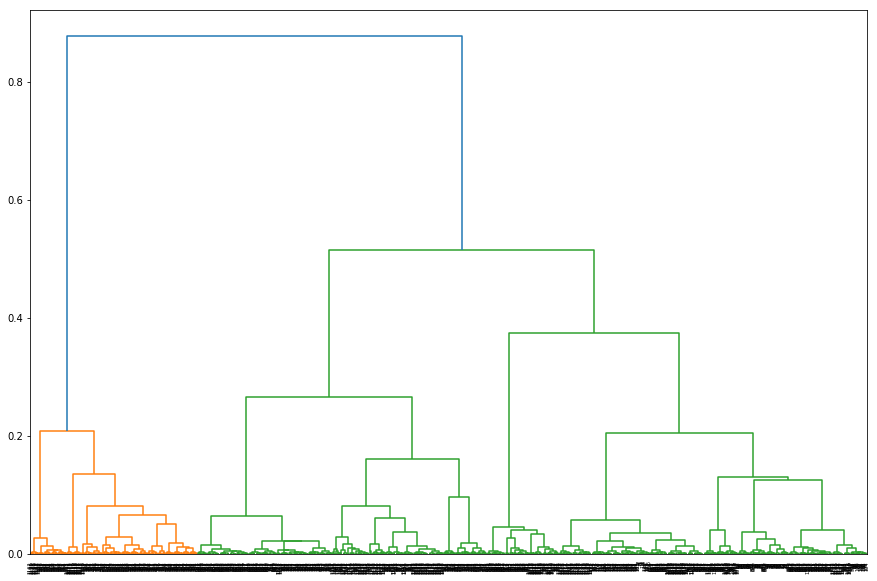

In [75]:
lon_lat = np.array(data27_apt.iloc[:,-2:])

linked = linkage(lon_lat, 'ward')

labelList = range(0, len(lon_lat))

plt.figure(figsize=(15, 10))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [76]:
cluster1 = AgglomerativeClustering(n_clusters=18, affinity='euclidean', linkage='ward')
cluster1.fit_predict(lon_lat)

array([3, 3, 3, ..., 4, 4, 4])

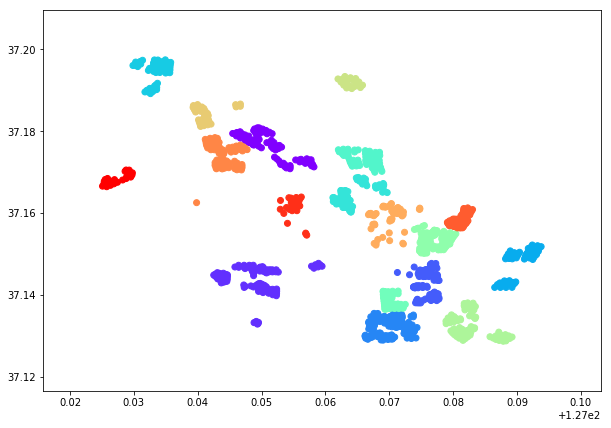

In [77]:
plt.figure(figsize=(10, 7))
plt.scatter(lon_lat[:,0], lon_lat[:,1], c=cluster1.labels_, cmap='rainbow')

In [78]:
data27_apt["cluster"] = cluster1.fit_predict(lon_lat)

/opt/app-root/lib/python3.6/site-packages/geopandas/geodataframe.py:1190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [79]:
apt_cluster = {"cluster":[],"lon":[], "lat":[]}

for i in range(18):
    apt_cluster["cluster"].append(i)
    apt_cluster["lon"].append(data27_apt[data27_apt.cluster == i].unary_union.centroid.x)
    apt_cluster["lat"].append(data27_apt[data27_apt.cluster == i].unary_union.centroid.y)
    
apt_cluster
apt_cluster_df = pd.DataFrame(apt_cluster)
apt_cluster_geo = gpd.GeoDataFrame(apt_cluster_df, geometry = gpd.points_from_xy(apt_cluster_df.lon,apt_cluster_df.lat))
apt_cluster_geo.crs = data2.crs # 아파트 단지별 중심점

In [80]:
distance_apt = [] # 중심점과의 거리

for i in data2['geometry']:
    temp = []
    for j in apt_cluster_geo['geometry']:
        temp.append(i.distance(j))
        
    distance_apt.append(min(temp))

+ 학원가 클러스터링도 동일한 방식으로 진행

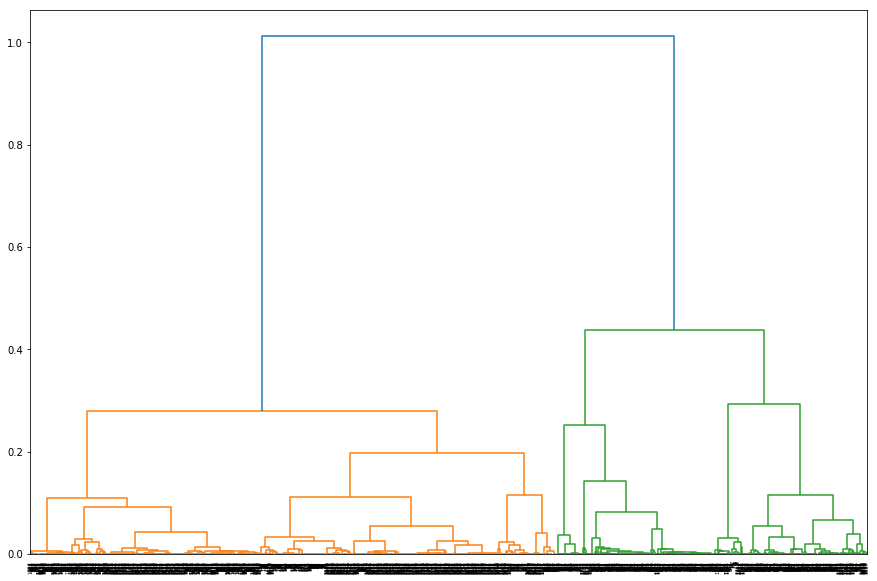

In [81]:
lon_lat2 = np.array(data30.iloc[:,-2:])

linked = linkage(lon_lat2, 'ward')

labelList = range(0, len(lon_lat2))

plt.figure(figsize=(15, 10))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [82]:
cluster2 = AgglomerativeClustering(n_clusters=12, affinity='euclidean', linkage='ward')
cluster2.fit_predict(lon_lat2)

array([3, 3, 3, ..., 6, 6, 9])

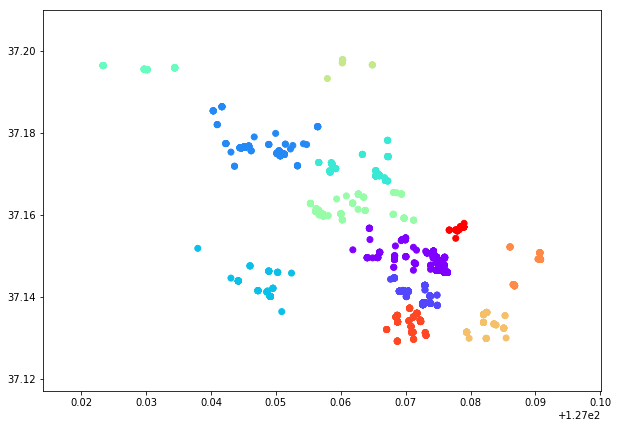

In [83]:
plt.figure(figsize=(10, 7))
plt.scatter(lon_lat2[:,0], lon_lat2[:,1], c=cluster2.labels_, cmap='rainbow')

In [84]:
data30["cluster"] = cluster2.fit_predict(lon_lat2)

data30_geo = gpd.GeoDataFrame(data30, geometry= gpd.points_from_xy(data30.시설위치_경도, data30.시설위치_위도))

In [85]:
aca_cluster = {"cluster":[],"lon":[], "lat":[]}

for i in range(12):
    aca_cluster["cluster"].append(i)
    aca_cluster["lon"].append(data30_geo[data30_geo.cluster == i].unary_union.centroid.x)
    aca_cluster["lat"].append(data30_geo[data30_geo.cluster == i].unary_union.centroid.y)
    

aca_cluster_df = pd.DataFrame(aca_cluster)
aca_cluster_geo = gpd.GeoDataFrame(aca_cluster_df, geometry = gpd.points_from_xy(aca_cluster_df.lon,aca_cluster_df.lat))
aca_cluster_geo.crs = data2.crs

In [86]:
distance_aca = []

for i in data2['geometry']:
    temp = []
    for j in aca_cluster_geo['geometry']:
        temp.append(i.distance(j))
    
    distance_aca.append(min(temp))    

In [87]:
data_test = data2.copy()
data_test["dst"] = distance_aca

In [88]:
# 시각화
m4 = folium.Map(location= [37.17,127.05],
           zoom_start=12,
           tiles='http://api.vworld.kr/req/wmts/1.0.0/367DCB08-CDE9-3198-ADA7-CB173AB35D97/Base/{z}/{y}/{x}.png',
           attr='오산시')


folium.Choropleth(
    geo_data=data2,
    data=data_test,
    columns=('gid', 'dst'),
    key_on='feature.properties.gid',
    fill_color='BuPu',
    legend_name='거리',
).add_to(m4)

m4

In [ ]:
# 3. 추가 변수 및 지표 생성

## 1. 교차로

+ 격자별 교통사고 건수 시각화 결과 횡단보도, 신호등이 많은 교차로에서 많이 발생하는 것을 확인
+ 격자내 교차로 개수 변수 생성

cross = [a in ["32", "4"] for a in data23.link_type] #교차로 통로, 복합 교차로
sum(cross)
#교차로 총 385개

cross_geo = data23[cross].buffer(0.0001).unary_union

data23_b = data23[cross].copy()
data23_b["geometry"] = data23_b["geometry"].buffer(0.0001).values #선분을 두껍게 buffer
data23_b.crs = data2.crs
data23_b["cross1"] = 1

merge_i = gpd.sjoin(data23_b, data2, op = "intersects", how = 'right')
cross1 = merge_i.groupby('gid').agg({'cross1': 'sum'})

## 2. 사거리, 삼거리

+ 도로유형상 교차로에 해당되지 않으나, 다수의 횡단로가 존재하는 사거리, 삼거리 변수 생성

#도로가 교차하는 모든 지점 추출
cross_dict = {}
data23_2 = data23[data23.link_type == "32768"]

for index, row in data23_2.iterrows():
    cross_dict[index] = []
    for index2, row2 in data23_2.drop([index], axis=0).iterrows():
        if row.geometry.intersects(row2.geometry):
            cross_dict[index].append(row.geometry.intersection(row2.geometry).coords[:])

cross_geo_dic = {"lon":[], "lat":[]}

for key, value in cross_dict.items():
    for i in range(len(value)):
        cross_geo_dic["lon"].append(value[i][0][0])
        cross_geo_dic["lat"].append(value[i][0][1])

cross_all = pd.DataFrame(cross_geo_dic).drop_duplicates()

cross_all_geo = gpd.GeoDataFrame(cross_all, geometry = gpd.points_from_xy(cross_all.lon, cross_all.lat))
cross_all_geo.crs = data2.crs

#각 사거리의 중점에서 근처 횡단보도까지의 거리 측정

distance_3 = []

for i in cross_all_geo['geometry']:
    temp = []
    for j in data17_p['geometry']:
        temp.append(i.distance(j))
    idx = temp.index(sorted(temp)[3])
    geom=[i,data17_p.iloc[idx,1]]
    gdf=gpd.GeoDataFrame(geometry=geom,crs={'init':'epsg:4326'})
    gdf.to_crs(epsg=5186,inplace=True) # 한국 중부 좌표계
    l_3=gdf.distance(gdf.shift())[1]
    distance_3.append(l_3)
    

cross_all_geo['crosswalk_1'] = distance_3

#pd.set_option("display.max_rows", None, "display.max_columns", None)
cross_all_geo["cross2"] = 1
cross_all_geo.sort_values("crosswalk_1")
cross_all_geo_cut = cross_all_geo[cross_all_geo.crosswalk_1 < 51]
#4번개 횡단보도와의 거리가 5미터 이하인 것들로 필터링

merge_j = gpd.sjoin(cross_all_geo_cut, data2, op = "within", how = 'right')
cross2 = merge_j.groupby('gid').agg({'cross2': 'sum'})



## 3. 격자별 유동인구

+ 시각화를 통해 학교보다 학원가 근처에서 어린이 교통사고가 다수 발생하는 것을 확인
+ 초등생들의 하교 시간대인 1~4시 사이의 격자별 유동인구 위주로 파악
+ 1월부터 12월까지 월별로 측정된 유동인구 데이터

+ 방학기간인 7-8, 1-2월과 그렇지 않은 기간으로 분리

vacation  = [a in [201907, 201908,201901,201902] for a in data8.STD_YM]
data8_s = data8[list(~np.array(vacation))]
data8_v = data8[vacation]

data8_s1 = data8_s.groupby(["lon","lat"]).mean()
data8_s1.reset_index(level=0, inplace=True)
data8_s1.reset_index(level=0, inplace=True)

data8_s_geo = gpd.GeoDataFrame(data8_s1, geometry= gpd.points_from_xy(data8_s1.lon, data8_s1.lat))
data8_s_geo.crs = data2.crs
merge_p = gpd.sjoin(data8_s_geo, data2[["gid","geometry"]], op='within', how="right")

#격자별 총 유동인구(학기중)
people_s  = merge_p.groupby("gid").sum()

# 동일한 방식으로 비학기 평균 유동인구
data8_v1 = data8_v.groupby(["lon","lat"]).mean()
data8_v1.reset_index(level=0, inplace=True)
data8_v1.reset_index(level=0, inplace=True)

data8_v_geo = gpd.GeoDataFrame(data8_v1, geometry= gpd.points_from_xy(data8_v1.lon, data8_v1.lat))
data8_v_geo.crs = data2.crs

merge_p2 = gpd.sjoin(data8_v_geo, data2[["gid","geometry"]], op='within', how="right")
people_v  = merge_p2.groupby("gid").sum()

plt.plot(people_s.mean()[4:-1], marker='s', color='r')
plt.plot(people_v.mean()[4:-1], marker='o', color='g')
plt.xticks(rotation = 90)
plt.figure(figsize=(50,30))
plt.show()

+ 실제로 방학시즌에 아침 저녁 유동인구가 더 적은 것 확인.
+ 학기중 유동인구 기준으로 변수 사용

moving = pd.merge(people_s, people_v, on = "gid",  how = "inner")
moving.drop(["index_left_x","lat_x","lon_x","STD_YM_x"], axis =1, inplace = True)

moving_log = moving.copy() 
moving_log.iloc[:,:] = np.log1p(moving_log.values) #skewness 감소를 위해 로그 취해줌



## 4. 아파트단지, 학원가 밀접도

+ 가장 가까운 주택가, 학원가로부터 얼마나 떨어져있는지를 변수로 수치화
+ 단순히 가장 가까운 건물로 할 시 변수가 지나치게 획일화될 수 있고 의미 해석도 모호해짐
+ 아파트 단지, 학원 단지를 군집화하여 가장 가까운 군집과의 거리를 측정

# 아파트 단지
apt_list = [s in ["02000","02001"] for s in data27.BDTYP_CD]
data27_apt = data27[apt_list]

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

data27_apt['lon'] = data27_apt['geometry'].centroid.x
data27_apt['lat'] = data27_apt['geometry'].centroid.y

data27_apt

lon_lat = np.array(data27_apt.iloc[:,-2:])

linked = linkage(lon_lat, 'ward')

labelList = range(0, len(lon_lat))

plt.figure(figsize=(15, 10))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

cluster1 = AgglomerativeClustering(n_clusters=18, affinity='euclidean', linkage='ward')
cluster1.fit_predict(lon_lat)

plt.figure(figsize=(10, 7))
plt.scatter(lon_lat[:,0], lon_lat[:,1], c=cluster1.labels_, cmap='rainbow')

data27_apt["cluster"] = cluster1.fit_predict(lon_lat)

apt_cluster = {"cluster":[],"lon":[], "lat":[]}

for i in range(18):
    apt_cluster["cluster"].append(i)
    apt_cluster["lon"].append(data27_apt[data27_apt.cluster == i].unary_union.centroid.x)
    apt_cluster["lat"].append(data27_apt[data27_apt.cluster == i].unary_union.centroid.y)
    
apt_cluster
apt_cluster_df = pd.DataFrame(apt_cluster)
apt_cluster_geo = gpd.GeoDataFrame(apt_cluster_df, geometry = gpd.points_from_xy(apt_cluster_df.lon,apt_cluster_df.lat))
apt_cluster_geo.crs = data2.crs # 아파트 단지별 중심점

distance_apt = [] # 중심점과의 거리

for i in data2['geometry']:
    temp = []
    for j in apt_cluster_geo['geometry']:
        temp.append(i.distance(j))
        
    distance_apt.append(min(temp))

+ 학원가 클러스터링도 동일한 방식으로 진행

lon_lat2 = np.array(data30.iloc[:,-2:])

linked = linkage(lon_lat2, 'ward')

labelList = range(0, len(lon_lat2))

plt.figure(figsize=(15, 10))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

cluster2 = AgglomerativeClustering(n_clusters=12, affinity='euclidean', linkage='ward')
cluster2.fit_predict(lon_lat2)

plt.figure(figsize=(10, 7))
plt.scatter(lon_lat2[:,0], lon_lat2[:,1], c=cluster2.labels_, cmap='rainbow')

data30["cluster"] = cluster2.fit_predict(lon_lat2)

data30_geo = gpd.GeoDataFrame(data30, geometry= gpd.points_from_xy(data30.시설위치_경도, data30.시설위치_위도))

aca_cluster = {"cluster":[],"lon":[], "lat":[]}

for i in range(12):
    aca_cluster["cluster"].append(i)
    aca_cluster["lon"].append(data30_geo[data30_geo.cluster == i].unary_union.centroid.x)
    aca_cluster["lat"].append(data30_geo[data30_geo.cluster == i].unary_union.centroid.y)
    

aca_cluster_df = pd.DataFrame(aca_cluster)
aca_cluster_geo = gpd.GeoDataFrame(aca_cluster_df, geometry = gpd.points_from_xy(aca_cluster_df.lon,aca_cluster_df.lat))
aca_cluster_geo.crs = data2.crs

distance_aca = []

for i in data2['geometry']:
    temp = []
    for j in aca_cluster_geo['geometry']:
        temp.append(i.distance(j))
    
    distance_aca.append(min(temp))    

data_test = data2.copy()
data_test["dst"] = distance_aca

# 시각화
m4 = folium.Map(location= [37.17,127.05],
           zoom_start=12,
           tiles='http://api.vworld.kr/req/wmts/1.0.0/367DCB08-CDE9-3198-ADA7-CB173AB35D97/Base/{z}/{y}/{x}.png',
           attr='오산시')


folium.Choropleth(
    geo_data=data2,
    data=data_test,
    columns=('gid', 'dst'),
    key_on='feature.properties.gid',
    fill_color='BuPu',
    legend_name='거리',
).add_to(m4)

m4